In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation with closed-form formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## Debug...

In [3]:
problem_name = "navier_stokes_2d_with_boundary"
alpha_for_f = 2

def f(x):
    return (1-x)**alpha_for_f * (1+x)**alpha_for_f

def fprime(x):
    return (
        -alpha_for_f 
        * (1-x)**(alpha_for_f-1) 
        * (1+x)**(alpha_for_f-1) 
        * 2*x
    )

def g(x):
    return 1 + x**2

def gprime(x):
    return 2 * x

t_lo, x_lo, x_hi = 0., -1, 1

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_points, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi + delta)
    plt.ylim(x_lo, x_hi)
    wall = np.linspace(x_lo, x_hi + delta, nb_points)
    wall_lo = x_lo * np.ones_like(wall)
    wall_hi = x_hi * np.ones_like(wall)
    plt.plot(wall, wall_lo, color="black",linewidth=lw)
    plt.plot(wall, wall_hi, color="black",linewidth=lw)

def plot_fluid(model, nb_points=20, x_lo=None, x_hi=None):
    # create x
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_points),
        np.linspace(x_lo, x_hi, nb_points)
    )
    x_tensor = torch.tensor(
        np.stack((np.zeros_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype()
    ).reshape(3, -1)
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    
    # calculate u
    u = (
        model(x_tensor.T, patch=0).T.detach().cpu()
    )
    u1_term = model.phi_fun(x_tensor[1:], 0).cpu()
    u2_term = model.phi_fun(x_tensor[1:], 1).cpu()
    
    # plot
    f = plt.figure()
    plot_wall(model, nb_points, x_lo, x_hi)
    plt.quiver(x1, x2, u1_term, u2_term)
    plt.title("Fluid flow at terminal time")
    f.savefig(f"{model.working_dir}/plot/terminal_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    magnitute = torch.sqrt(u1_term**2 + u2_term**2).reshape(nb_points, nb_points)
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute,
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower')
    f.colorbar(im)
    plt.title("Fluid flow at terminal time")
    f.savefig(f"{model.working_dir}/plot/terminal_flow_color.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    f = plt.figure()
    plot_wall(model, nb_points, x_lo, x_hi)
    plt.quiver(x1, x2, u[0], u[1])
    plt.title("Fluid flow at t = 0")
    f.savefig(f"{model.working_dir}/plot/t0_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    magnitute = torch.sqrt(u[0]**2 + u[1]**2).reshape(nb_points, nb_points)
    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute,
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title("Fluid flow at t = 0")
    f.savefig(f"{model.working_dir}/plot/t0_flow_color.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    return x1, x2, u, u1_term, u2_term

In [4]:
def plot_poisson(model, nb_points=100, x_lo=None, x_hi=None):
    # create x
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1]
    )
    x_tensor = torch.tensor(
        np.stack((x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype(),
        requires_grad=True,
    ).reshape(2, -1)

    # calculate poisson rhs and lhs
    poisson_rhs = 0
    order = np.array([0] * model.dim_in)
    # xx = x.T.detach().clone().requires_grad_(True)
    for i in range(model.dim_in):
        for j in range(model.dim_in):
            order[i] += 1
            tmp = model.nth_derivatives(
                order, model.phi_fun(x_tensor, j), x_tensor
            )
            order[i] -= 1
            order[j] += 1
            tmp *= model.nth_derivatives(
                order, model.phi_fun(x_tensor, i), x_tensor
            )
            order[j] -= 1
            poisson_rhs -= tmp
    poisson_rhs = poisson_rhs.reshape(nb_points, nb_points).detach().cpu()
    poisson_lhs = 0
    for i in range(model.dim_in):
        order[i] += 2
        poisson_lhs += model.nth_derivatives(
            order, model(x_tensor.T, p_or_u="p", patch=0), x_tensor
        )
        order[i] -= 2
    poisson_lhs = poisson_lhs.reshape(nb_points, nb_points).detach().cpu()

    # plot
    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        poisson_lhs,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title("Poisson LHS, Laplacian p")
    plt.show()
    plt.close()

    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        poisson_rhs,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title("Poisson RHS, -div div u x u")
    plt.show()
    plt.close()
    
    return poisson_lhs, poisson_rhs

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220601-211901-navier_stokes_2d_with_boundary-T0.001-nu2
Patch 0: generation of p samples take 123.56359457969666 seconds.
Patch  0: epoch    0 with loss 4.64E+00
Patch  0: epoch  500 with loss 5.10E-03
Patch  0: epoch 1000 with loss 4.60E-03
Patch  0: epoch 1500 with loss 1.38E-03
Patch  0: epoch 2000 with loss 1.82E-03
Patch  0: epoch 2500 with loss 8.10E-04
Patch  0: epoch 3000 with loss 6.82E-04
Patch  0: epoch 3500 with loss 1.26E-03
Patch  0: epoch 4000 with loss 8.78E-04
Patch  0: epoch 4500 with loss 4.72E-04
Patch  0: epoch 5000 with loss 1.63E-03
Patch  0: epoch 5500 with loss 7.43E-04
Patch  0: epoch 6000 with loss 3.53E-04
Patch  0: epoch 6500 with loss 3.05E-03
Patch  0: epoch 7000 with loss 9.01E-04
Patch  0: epoch 7500 with loss 8.53E-04
Patch  0: epoch 8000 with loss 7.58E-04
Patch  0: epoch 8500 with loss 7.08E-04
Patch  0: epoch 9000 with loss 9.42E-04
Patch  0: epoch 9500 with loss 8.97E-04
Patch  

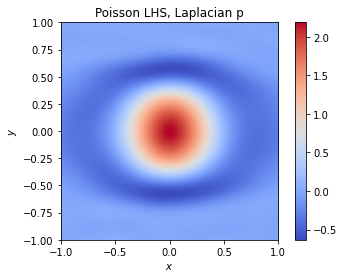

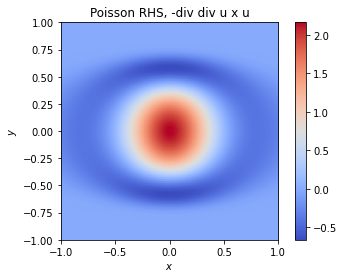

In [5]:
nu = 2
patches = 1
T = patches * .001
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    train_for_u=False,
)
model.train_and_eval(debug_mode=False)
lhs, rhs = plot_poisson(model)

In [6]:
print(f"The L2 difference between LHS and RHS is {model.loss(lhs, rhs):.2E}.")

The L2 difference between LHS and RHS is 3.22E-04.


## Using the Poisson above for the simulation of u 

### T = .01

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220601-213156-navier_stokes_2d_with_boundary-T0.01-nu2
Patch 0: generation of u samples take 632.821391582489 seconds.
Patch  0: epoch    0 with loss 7.06E+00
Patch  0: epoch  500 with loss 6.79E-04
Patch  0: epoch 1000 with loss 4.24E-02
Patch  0: epoch 1500 with loss 1.03E-03
Patch  0: epoch 2000 with loss 4.31E-04
Patch  0: epoch 2500 with loss 1.14E-03
Patch  0: epoch 3000 with loss 1.43E-03
Patch  0: epoch 3500 with loss 3.67E-04
Patch  0: epoch 4000 with loss 2.05E-04
Patch  0: epoch 4500 with loss 1.99E-03
Patch  0: epoch 5000 with loss 3.60E-04
Patch  0: epoch 5500 with loss 1.65E-04
Patch  0: epoch 6000 with loss 8.89E-05
Patch  0: epoch 6500 with loss 6.25E-02
Patch  0: epoch 7000 with loss 8.75E-04
Patch  0: epoch 7500 with loss 4.67E-04
Patch  0: epoch 8000 with loss 1.77E-04
Patch  0: epoch 8500 with loss 5.66E-04
Patch  0: epoch 9000 with loss 1.16E-04
Patch  0: epoch 9500 with loss 1.08E-04
Patch  0: 

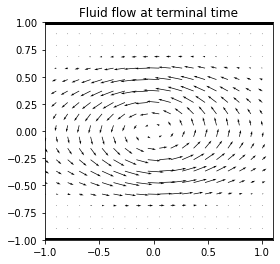

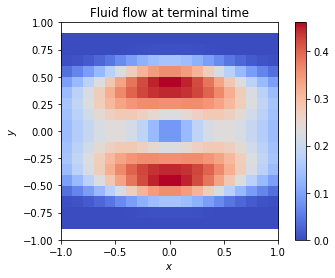

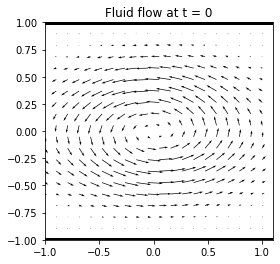

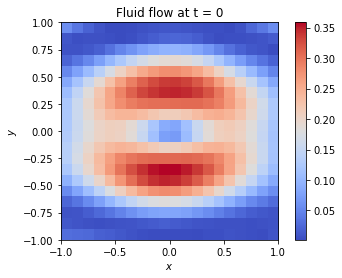

In [5]:
nu = 2
patches = 1
T = patches * .01
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220601-211901-navier_stokes_2d_with_boundary-T0.001-nu2"
)
model.train_and_eval(debug_mode=False)
x1, x2, u, u1_term, u2_term = plot_fluid(model)

### T = .1

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220601-214622-navier_stokes_2d_with_boundary-T0.1-nu2
Patch 0: generation of u samples take 580.1147429943085 seconds.
Patch  0: epoch    0 with loss 6.98E+00
Patch  0: epoch  500 with loss 2.67E-04
Patch  0: epoch 1000 with loss 8.90E-04
Patch  0: epoch 1500 with loss 7.64E-03
Patch  0: epoch 2000 with loss 2.97E-04
Patch  0: epoch 2500 with loss 8.49E-04
Patch  0: epoch 3000 with loss 1.25E-04
Patch  0: epoch 3500 with loss 2.14E-03
Patch  0: epoch 4000 with loss 2.45E-04
Patch  0: epoch 4500 with loss 1.86E-04
Patch  0: epoch 5000 with loss 3.09E-04
Patch  0: epoch 5500 with loss 1.60E-04
Patch  0: epoch 6000 with loss 8.02E-05
Patch  0: epoch 6500 with loss 6.63E-05
Patch  0: epoch 7000 with loss 1.93E-02
Patch  0: epoch 7500 with loss 6.35E-04
Patch  0: epoch 8000 with loss 1.46E-03
Patch  0: epoch 8500 with loss 8.43E-05
Patch  0: epoch 9000 with loss 1.21E-03
Patch  0: epoch 9500 with loss 2.11E-04
Patch  0: 

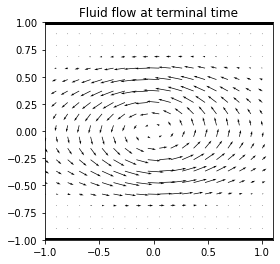

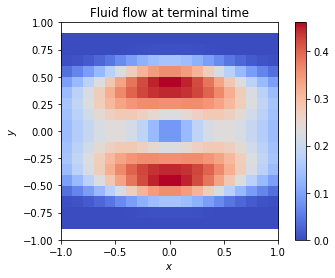

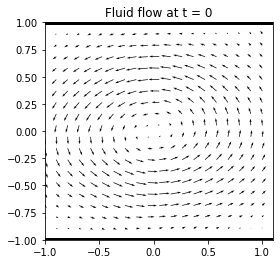

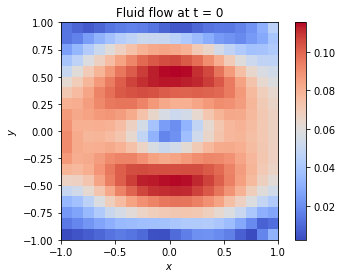

In [6]:
nu = 2
patches = 1
T = patches * .1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220601-211901-navier_stokes_2d_with_boundary-T0.001-nu2"
)
model.train_and_eval(debug_mode=False)
x1, x2, u, u1_term, u2_term = plot_fluid(model)

### T = 1

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220601-215954-navier_stokes_2d_with_boundary-T1-nu2
Patch 0: generation of u samples take 433.2606854438782 seconds.
Patch  0: epoch    0 with loss 6.99E+00
Patch  0: epoch  500 with loss 1.19E-04
Patch  0: epoch 1000 with loss 7.24E-04
Patch  0: epoch 1500 with loss 4.45E-04
Patch  0: epoch 2000 with loss 6.39E-03
Patch  0: epoch 2500 with loss 1.16E-04
Patch  0: epoch 3000 with loss 1.04E-03
Patch  0: epoch 3500 with loss 6.39E-04
Patch  0: epoch 4000 with loss 1.90E-04
Patch  0: epoch 4500 with loss 3.00E-04
Patch  0: epoch 5000 with loss 2.71E-03
Patch  0: epoch 5500 with loss 5.50E-04
Patch  0: epoch 6000 with loss 9.02E-05
Patch  0: epoch 6500 with loss 8.91E-05
Patch  0: epoch 7000 with loss 5.31E-04
Patch  0: epoch 7500 with loss 3.40E-04
Patch  0: epoch 8000 with loss 4.98E-05
Patch  0: epoch 8500 with loss 8.23E-05
Patch  0: epoch 9000 with loss 3.88E-05
Patch  0: epoch 9500 with loss 2.17E-05
Patch  0: ep

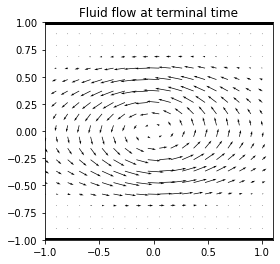

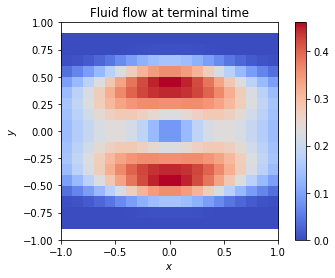

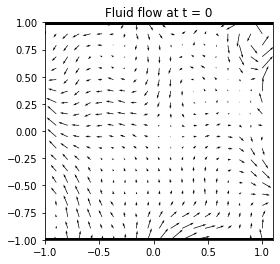

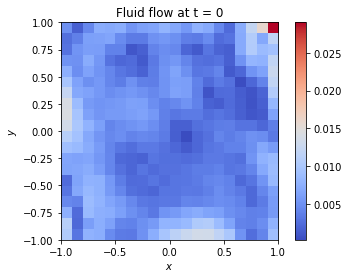

In [7]:
nu = 2
patches = 1
T = patches * 1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220601-211901-navier_stokes_2d_with_boundary-T0.001-nu2"
)
model.train_and_eval(debug_mode=False)
x1, x2, u, u1_term, u2_term = plot_fluid(model)